<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/FINANCE_AI_AGENT_OPENAI_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openai yfinance colab-env -q
!pip install openai-agents -q

In [ ]:
import colab_env
from openai import OpenAI
import os


#client = OpenAI()
client = OpenAI(api_key = os.getenv("OPENAI_API_KEY"))

In [8]:
import openai
import os
import sqlite3
import yfinance as yf
import asyncio
import nest_asyncio
from agents import Agent, Tool, Runner
import random
import re
import logging
import typing  # Import typing for type hints

# Set up logging
logging.basicConfig(level=logging.INFO, filename="financial_analysis.log")
logger = logging.getLogger(__name__)

# Configuration
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
DB_NAME = "financial_data.db"

nest_asyncio.apply()
openai.api_key = OPENAI_API_KEY


# 1. Initialize the SQLite Database
def initialize_database(db_name=DB_NAME):
    """Initializes the SQLite database."""
    try:
        with sqlite3.connect(db_name) as conn:
            cursor = conn.cursor()
            cursor.execute(
                """
                CREATE TABLE IF NOT EXISTS stocks (
                    ticker TEXT PRIMARY KEY,
                    company_name TEXT,
                    sector TEXT
                )
            """
            )
            cursor.execute(
                """
                CREATE TABLE IF NOT EXISTS historical_prices (
                    ticker TEXT,
                    date TEXT,
                    close REAL,
                    volume INTEGER,
                    PRIMARY KEY (ticker, date),
                    FOREIGN KEY (ticker) REFERENCES stocks(ticker)
                )
            """
            )
            logger.info("Database initialized.")
            print("Database initialized.")
    except sqlite3.Error as e:
        logger.error(f"SQLite Error: {e}", exc_info=True)
        print(f"SQLite Error: {e}")

# 2. Populate the Database
def populate_apple_data(db_name=DB_NAME, ticker="AAPL", years=25):
    """Populates the database with Apple's data."""
    try:
        with sqlite3.connect(db_name) as conn:
            cursor = conn.cursor()
            stock = yf.Ticker(ticker)
            history = stock.history(period=f"{years}y")
            if history.empty:
                logger.warning(f"No data found for ticker {ticker}.")
                print(f"No data found for ticker {ticker}.")
                return

            cursor.execute(
                "INSERT OR IGNORE INTO stocks VALUES (?, ?, ?)",
                (ticker, "Apple Inc.", "Technology"),
            )

            for date, row in history.iterrows():
                date_str = date.strftime("%Y-%m-%d")
                cursor.execute(
                    "INSERT OR IGNORE INTO historical_prices VALUES (?, ?, ?, ?)",
                    (ticker, date_str, row["Close"], int(row["Volume"])),
                )

            logger.info(f"Successfully stored Apple's data for the last {years} years.")
            print(f"Successfully stored Apple's data for the last {years} years.")

    except Exception as e:
        logger.error(f"Error populating database with Apple data: {e}", exc_info=True)
        print(f"Error populating database with Apple data: {e}")

# 3. Define a Function Tool to Use SQLite
def analyze_stock_data_from_db(ticker, db_name=DB_NAME):
    """Analyzes historical stock data."""
    try:
        with sqlite3.connect(db_name) as conn:
            cursor = conn.cursor()
            # Combine queries for efficiency
            cursor.execute(
                """
                SELECT close, AVG(volume)
                FROM historical_prices
                WHERE ticker = ?
                ORDER BY date DESC
                LIMIT 1
                """,
                (ticker,),
            )
            result = cursor.fetchone()
            if result:
                recent_price, average_volume = result
                analysis = f"Stock analysis for {ticker} (from SQLite DB):\n"
                analysis += f"  Recent closing price: ${recent_price:.2f}\n"
                analysis += f"  Average trading volume: {average_volume:.0f}\n"
                return analysis
            else:
                return f"No recent price data found for ticker {ticker}."
    except Exception as e:
        logger.error(f"Error analyzing stock data for {ticker}: {e}", exc_info=True)
        return f"Error analyzing stock data for {ticker}: {e}"

initialize_database()
populate_apple_data()

Database initialized.
Successfully stored Apple's data for the last 25 years.


In [9]:
import sqlite3

# Assuming your database functions are defined and data is populated
DB_NAME = "financial_data.db"


def calculate_basic_metrics_with_year(ticker="AAPL", db_name=DB_NAME):
    """Calculates basic financial metrics and includes the year."""
    try:
        with sqlite3.connect(db_name) as conn:
            cursor = conn.cursor()

            # 1. Get the most recent closing price, date, and year
            cursor.execute(
                """
                SELECT Close, Date, strftime('%Y', Date) AS Year
                FROM historical_prices
                WHERE ticker = ?
                ORDER BY date DESC
                LIMIT 1
                """,
                (ticker,),
            )
            recent_price, recent_date, recent_year = cursor.fetchone()

            # 2. Calculate the average closing price over the last 30 days
            cursor.execute(
                """
                SELECT AVG(Close)
                FROM historical_prices
                WHERE ticker = ?
                AND date >= date('now', '-30 days')
                """,
                (ticker,),
            )
            avg_price_30_days = cursor.fetchone()[0]

            # 3. Calculate the price change percentage over the last 30 days
            price_change_percentage = (
                (recent_price - avg_price_30_days) / avg_price_30_days
            ) * 100
            # Display the results including the year
            print(f"Basic Financial Metrics for {ticker} (Data Year: {recent_year}):")
            print(f"  Recent Closing Price: ${recent_price:.2f} (on {recent_date})")
            print(f"  Average Closing Price (Last 30 Days): ${avg_price_30_days:.2f}")
            print(
                f"  Price Change Percentage (Last 30 Days): {price_change_percentage:.2f}%"
            )

    except Exception as e:
        print(f"Error calculating basic metrics: {e}")


# Run the analysis
calculate_basic_metrics_with_year()

Basic Financial Metrics for AAPL (Data Year: 2025):
  Recent Closing Price: $209.68 (on 2025-03-13)
  Average Closing Price (Last 30 Days): $236.97
  Price Change Percentage (Last 30 Days): -11.52%


In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

# Database name
DB_NAME = "financial_data.db"

def simple_regression_poc(ticker="AAPL", db_name=DB_NAME):
    """Performs a simple linear regression and plots the results."""
    try:
        with sqlite3.connect(db_name) as conn:
            cursor = conn.cursor()

            # Fetch yearly average closing prices (simplified query)
            cursor.execute(
                """
                SELECT strftime('%Y', Date), AVG(Close)
                FROM historical_prices
                WHERE ticker = ?
                GROUP BY 1
                ORDER BY 1
                """,
                (ticker,),
            )
            data = cursor.fetchall()

            # Extract years and average prices
            years, avg_prices = zip(*data)  # Using zip for direct unpacking
            years = np.array([int(year) for year in years])  # Convert to numerical
            avg_prices = np.array(avg_prices)

            # Perform linear regression
            slope, intercept = np.polyfit(years, avg_prices, 1)
            regression_line = slope * years + intercept

            # Plot the results (simplified plotting)
            plt.plot(years, avg_prices, 'o', label="Average Prices")
            plt.plot(years, regression_line, label="Regression Line")
            plt.xlabel("Year")
            plt.ylabel("Average Closing Price")
            plt.title(f"Simple Regression POC for {ticker}")
            plt.legend()
            plt.show()

    except Exception as e:
        print(f"Error: {e}")


# Run the POC
simple_regression_poc()

+--------+-------------------------+
|   Year |   Average Closing Price |
+========+=========================+
|   2000 |                0.652966 |
+--------+-------------------------+
|   2001 |                0.304238 |
+--------+-------------------------+
|   2002 |                0.287987 |
+--------+-------------------------+
|   2003 |                0.279039 |
+--------+-------------------------+
|   2004 |                0.534567 |
+--------+-------------------------+
|   2005 |                1.40465  |
+--------+-------------------------+
|   2006 |                2.13095  |
+--------+-------------------------+
|   2007 |                3.86022  |
+--------+-------------------------+
|   2008 |                4.27266  |
+--------+-------------------------+
|   2009 |                4.41817  |
+--------+-------------------------+
|   2010 |                7.81959  |
+--------+-------------------------+
|   2011 |               10.9542   |
+--------+-------------------------+
|

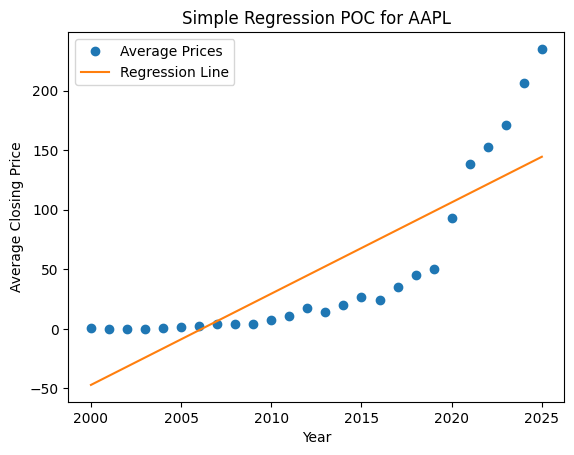

In [11]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate # Import tabulate for table formatting

# Database name
DB_NAME = "financial_data.db"

def simple_regression_poc_with_printed_table(ticker="AAPL", db_name=DB_NAME):
    """Performs a simple linear regression, plots the results, and prints a table."""
    try:
        with sqlite3.connect(db_name) as conn:
            cursor = conn.cursor()

            # Fetch yearly average closing prices
            cursor.execute(
                """
                SELECT strftime('%Y', Date), AVG(Close)
                FROM historical_prices
                WHERE ticker = ?
                GROUP BY 1
                ORDER BY 1
                """,
                (ticker,),
            )
            data = cursor.fetchall()

            # --- Table Printing ---
            headers = ["Year", "Average Closing Price"]
            print(tabulate(data, headers=headers, tablefmt="grid"))
            # --- End Table Printing ---

            # Extract years and average prices for regression and plotting
            years, avg_prices = zip(*data)
            years = np.array([int(year) for year in years])
            avg_prices = np.array(avg_prices)

            # Perform linear regression
            slope, intercept = np.polyfit(years, avg_prices, 1)
            regression_line = slope * years + intercept

            # Plot the results
            plt.plot(years, avg_prices, 'o', label="Average Prices")
            plt.plot(years, regression_line, label="Regression Line")
            plt.xlabel("Year")
            plt.ylabel("Average Closing Price")
            plt.title(f"Simple Regression POC for {ticker}")
            plt.legend()
            plt.show()

    except Exception as e:
        print(f"Error: {e}")


# Run the POC with table printing
simple_regression_poc_with_printed_table()

In [12]:
import yfinance as yf

def get_market_cap(ticker="AAPL"):
    """Retrieves and formats the market capitalization of a stock."""
    try:
        stock = yf.Ticker(ticker)
        market_cap = stock.info.get("marketCap")
        if market_cap is not None:
            # Format the market cap with commas and appropriate units
            formatted_market_cap = "{:,.0f}".format(market_cap)

            # You can also add units like Billion, Million, etc.
            if market_cap >= 1e12:  # Trillion
                formatted_market_cap += " Trillion"
            elif market_cap >= 1e9:  # Billion
                formatted_market_cap += " Billion"
            elif market_cap >= 1e6:  # Million
                formatted_market_cap += " Million"

            return f"The market capitalization of {ticker} is: {formatted_market_cap}"
        else:
            return f"Market capitalization not found for {ticker}"
    except Exception as e:
        return f"Error retrieving market capitalization: {e}"

# Get and print the formatted market capitalization of Apple
market_cap_info = get_market_cap()
print(market_cap_info)

The market capitalization of AAPL is: 3,149,833,961,472 Trillion


In [13]:
import re

#def extract_predicted_price(text: str) -> float:
 #   """
  #  Extracts the predicted price (numerical value) from the agent's output string.
  #  """
   # match = re.search(r"[$](\d+\.?\d*)", text)  # Matches a dollar sign followed by numbers
 #   if match:
 #       return float(match.group(1))
 #   else:
 #       return None  # Or raise an exception if price extraction is crucial

In [14]:
from agents import Agent, function_tool, Runner
import numpy as np
import sqlite3
from datetime import date
from dateutil.relativedelta import relativedelta
import asyncio

# Database name
DB_NAME = "financial_data.db"

# Tool functions with @function_tool decorator
@function_tool
def regression_tool(years: list[int], avg_prices: list[float]) -> float:
    """Performs linear regression and predicts the price in 6 months."""
    x = np.array(years)
    y = np.array(avg_prices)
    slope, intercept = np.polyfit(x, y, 1)
    future_year = years[-1] + 0.5
    predicted_price = slope * future_year + intercept
    return predicted_price

@function_tool
def data_retrieval_tool(ticker: str):
    """Retrieves historical stock data from the database."""
    try:
        with sqlite3.connect(DB_NAME) as conn:
            cursor = conn.cursor()
            cursor.execute(
                """
                SELECT strftime('%Y', Date), AVG(Close)
                FROM historical_prices
                WHERE ticker = ?
                GROUP BY 1
                ORDER BY 1
                """,
                (ticker,),
            )
            data = cursor.fetchall()
            return data
    except Exception as e:
        print(f"Error retrieving data: {e}")
        return []  # Return an empty list in case of error

@function_tool
def time_calculation_tool():
    """Calculates the date 6 months from now."""
    six_months_from_now = date.today() + relativedelta(months=+6)
    return six_months_from_now.strftime('%Y-%m-%d')


def generate_financial_analysis_prompt(
    ticker: str,
    analysis_type: str,
    time_period: str = None,
    indicators: list = None,
    constraints: dict = None
) -> str:
    """
    Generates a dynamic prompt for financial analysis of a given stock.
    (As defined previously, with modifications)
    """

    prompt = f"Perform a {analysis_type} analysis of {ticker}."

    if analysis_type == "analysis of prediction": # Handle new analysis type
      prompt = f"Analyze the following price prediction for {ticker}:"
      if constraints and "predicted_price" in constraints:
        prompt += f" Predicted price: ${constraints['predicted_price']}"

    elif time_period:
        prompt += f" Analyze the data for the past {time_period}."

    if indicators:
        prompt += " Include the following technical indicators in your analysis:\n"
        for indicator in indicators:
            prompt += f"- {indicator}\n"

    if constraints:
        prompt += " Please consider the following constraints:\n"
        for key, value in constraints.items():
            prompt += f"- {key}: {value}\n"

    prompt += """
    Your analysis should include:
    - Key financial metrics (e.g., price, volume, market cap).
    - Trends and patterns in the data.
    - An interpretation of the analysis based on the given constraints.
    - If applicable, a prediction of future price movements.
    """

    return prompt

# Create the agent
agent = Agent(
    name="FinancialPredictionAgent",
    tools=[regression_tool, data_retrieval_tool, time_calculation_tool],  # Pass the decorated functions directly
    instructions="""You are a financial prediction agent.
                     Your task is to predict the price of AAPL in 6 months.
                     Use the provided tools to analyze historical data and make a prediction.
                     First, retrieve historical data for AAPL using the data_retrieval_tool.
                     Then, use the regression_tool with the retrieved data to make the prediction.
                     """,
)


initial_prompt="Predict the price of AAPL in 6 months."
async def main():
    prediction_result = await Runner.run(agent, input=initial_prompt)
    #print(prediction_result.final_output)

    # Generate Analysis Prompt (Dynamic)
    analysis_prompt = generate_financial_analysis_prompt(
        ticker="AAPL",
        analysis_type="analysis of prediction",
        constraints={"focus_on_reasoning": True}
    )
    analysis_prompt += f" Analyze this prediction: {prediction_result}"  # More focused prompt

    # Run Agent for Analysis of Prediction
    final_result = await Runner.run(agent, input=analysis_prompt)

    #Process Final Result
    #print('\n')
    print("Agent's Analysis of Prediction:")
    print('\n')
    print(final_result.final_output)

if __name__ == "__main__":
    asyncio.run(main())

Agent's Analysis of Prediction:


### Analysis of AAPL Price Prediction

#### Key Financial Metrics

1. **Price Trend:**
   - Historical prices for AAPL are provided from the year 2000 to 2025.
   - Notable increase in price, particularly in recent years, showing a strong upward trend.

2. **Market Trends:**
   - Significant shifts in pricing, especially around 2020 and onward.
   - This could indicate broader market trends or company-specific achievements.

3. **Volume and Market Cap:**
   - Not directly included in the analysis, but typically, a rise in price can correlate with increased volume and market cap.

#### Trends and Patterns in the Data

1. **Upward Trajectory:**
   - The price of AAPL has consistently increased over the years.
   - Large jumps observed around 2020 indicate possible technological advancements or positive market influences.

2. **Regression Analysis:**
   - Used past data points for prediction.
   - The prediction of $148.27 in 6 months suggests a steady ri